In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
prices_2025 = pd.read_csv('data/sp500_test_prices.csv', index_col=0)

In [182]:
sp500_companies_all_data = pd.read_csv('data/sp500_prices.csv', index_col=0)
sp500_companies_all_data.index = pd.to_datetime(sp500_companies_all_data.index)
# clip dates from 2023 - end of 2024
sp500_companies_data = sp500_companies_all_data.loc['2023-01-01':'2024-12-31']
all_returns = sp500_companies_data.resample('M').last().pct_change().iloc[1:]
all_returns = all_returns.dropna(axis=1)
corr_all_returns = all_returns.corr()

/var/folders/bt/709h7c513ld30l7ynqg_cv0c0000gn/T/ipykernel_94895/632885602.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  all_returns = sp500_companies_data.resample('M').last().pct_change().iloc[1:]


In [183]:
sp500_companies_data.isna().sum().sort_values(ascending=False).head(20)

AMTM    433
SW      378
SOLV    311
GEV     311
VLTO    189
KVUE     84
NEM       0
NFLX      0
NI        0
NKE       0
NDSN      0
NOC       0
NOW       0
NRG       0
NSC       0
NTAP      0
NTRS      0
NEE       0
NDAQ      0
NVDA      0
dtype: int64

### Portfolio Optimization Problem Setup

We construct a monthly-rebalanced, long-only portfolio of S&P 500 stocks using a **factor-based risk model** and convex optimization. The goal is to:

- **Maximise expected return**
- **Minimise portfolio risk** (variance)
- **Select a small, implementable subset of stocks** using L1 sparsity

---

#### 🧮 Objective Function

We minimise the following:

$$
\mathcal{L}(w) = 
- \alpha \cdot \mu^\top w \quad \text{(maximize expected return)} \\
+ \beta \cdot w^\top \Sigma w \quad \text{(penalise volatility)} \\
+ \delta \cdot \|w\|_1 \quad \text{(encourage sparsity / stock selection)}
$$

Where:

- $w \in \mathbb{R}^n$ = portfolio weights  
- $\mu$ = expected return vector (monthly means)  
- $\Sigma$ = covariance matrix estimated from PCA (factor risk model)  
- $\alpha, \beta, \delta$ = tunable hyperparameters

---

#### 📐 Constraints

- Fully invested:   $\sum w_i = 1$  
- Long-only:     $w_i \ge 0$  
- Max position size: $w_i \le 0.15$

---

#### 💡 Reasoning

- We express the problem as a **minimization** to comply with `cvxpy` conventions.
- The return term is multiplied by `-alpha` so that *minimizing* it is equivalent to *maximising* return.
- The L1 penalty $\|w\|_1$ encourages **stock selection** (sparsity), limiting the number of names held.
- **Diversification** is achieved through the **quadratic risk term** $w^\top \Sigma w$, which naturally penalises concentrated or correlated bets.
- Using a **factor-based covariance matrix** (via PCA) ensures the risk model is stable and positive semi-definite, even with limited return history.

In [175]:
### Use PCA factor model
scaler = StandardScaler()
all_returns_scaled = scaler.fit_transform(all_returns)

# PCA
K = 20
pca = PCA(n_components=K)
all_returns_pca = pca.fit_transform(all_returns_scaled)
B = pca.components_.T
Phi = np.cov(all_returns_pca, rowvar=False)
Psi = np.diag(np.var(all_returns_scaled - all_returns_pca @ B.T, axis=0))
Sigma_factor = B @ Phi @ B.T + Psi

mu = all_returns.mean().values

n = len(mu)                              # mu = expected returns vector
w = cp.Variable(n)

Sigma_p = cp.Parameter((n, n), PSD=True)
Sigma_p.value = Sigma_factor
portfolio_vol = cp.quad_form(w, Sigma_p)

alpha = 1.0
beta  = 5
delta = 0.05

objective = cp.Minimize(
    -alpha * (mu @ w) +
     beta  * portfolio_vol +
     delta * cp.norm1(w)
)

constraints = [
    cp.sum(w) == 1,
    w >= 0,
   # w <= 0.15
]

problem = cp.Problem(objective, constraints)
problem.solve()

opt_weights = pd.Series(w.value, index=all_returns.columns).loc[lambda s: s>1e-4]
print(opt_weights.head(20))

/opt/anaconda3/envs/trading/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:241: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


ACGL     0.056120
AMGN     0.090362
AVGO     0.171964
CBOE     0.038704
CPB      0.036026
DELL     0.031295
EG       0.022142
EQT      0.045007
ETR      0.021618
GIS      0.005843
GOOG     0.025588
GOOGL    0.029763
HUM      0.059526
LULU     0.051407
NOC      0.105662
SMCI     0.071135
TPL      0.072075
UAL      0.065783
dtype: float64


# Evaluate the portfolio

In [192]:
sp500_companies_metadata = pd.read_csv('data/sp500_companies.csv', index_col=0)
sp500_companies_metadata.reset_index(drop=True, inplace=True)


In [194]:
selected_stocks = opt_weights.index
selected_stocks_metadata = sp500_companies_metadata[sp500_companies_metadata['Symbol'].isin(selected_stocks)]
selected_stocks_metadata

,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
4,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309
5,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,192.96,2351623045120,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309
8,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,220.79,1031217348608,2.295800e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.018553
67,AMGN,Amgen Inc.,Amgen Inc.,Healthcare,Drug Manufacturers - General,263.38,141575438336,1.224700e+10,0.232,Thousand Oaks,CA,United States,26700.0,"Amgen Inc. discovers, develops, manufactures, ...",0.002547
122,DELL,Dell Technologies Inc.,Dell Technologies Inc.,Technology,Computer Hardware,115.77,81092141056,8.726000e+09,0.091,Round Rock,TX,United States,120000.0,"Dell Technologies Inc. designs, develops, manu...",0.001459
147,NOC,Northrop Grumman Corporation,Northrop Grumman Corporation,Industrials,Aerospace & Defense,469.54,68409634816,4.458000e+09,0.023,Falls Church,VA,United States,101000.0,Northrop Grumman Corporation operates as an ae...,0.001231
199,LULU,lululemon athletica inc.,Lululemon Athletica Inc.,Consumer Cyclical,Apparel Retail,379.42,46207287296,2.699965e+09,0.073,Vancouver,BC,Canada,38000.0,"Lululemon Athletica Inc., together with its su...",0.000831
255,GIS,"General Mills, Inc.","General Mills, Inc.",Consumer Defensive,Packaged Foods,63.61,35063803904,4.214600e+09,-0.012,Minneapolis,MN,United States,34000.0,"General Mills, Inc. manufactures and markets b...",0.000631
260,ACGL,Arch Capital Group Ltd.,Arch Capital Group Ltd.,Financial Services,Insurance - Diversified,90.99,34234257408,5.172000e+09,0.418,Pembroke,NaN,Bermuda,6400.0,"Arch Capital Group Ltd., together with its sub...",0.000616
267,ETR,Entergy Corporation,Entergy Corporation,Utilities,Utilities - Regulated Electric,75.13,32216944640,4.596974e+09,-0.057,New Orleans,LA,United States,12000.0,"Entergy Corporation, together with its subsidi...",0.000580


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Technology'),
  Text(1, 0, 'Financial Services'),
  Text(2, 0, 'Communication Services'),
  Text(3, 0, 'Healthcare'),
  Text(4, 0, 'Industrials'),
  Text(5, 0, 'Consumer Defensive'),
  Text(6, 0, 'Energy'),
  Text(7, 0, 'Consumer Cyclical'),
  Text(8, 0, 'Utilities')])

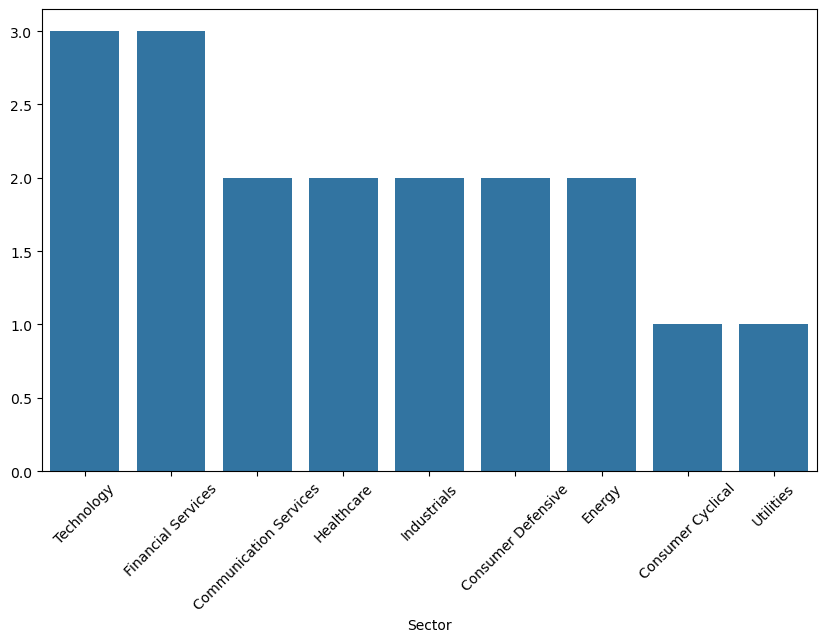

In [196]:
## look at sector distribution
sector_distribution = selected_stocks_metadata['Sector'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_distribution.index, y=sector_distribution.values)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Internet Content & Information'),
  Text(1, 0, 'Computer Hardware'),
  Text(2, 0, 'Packaged Foods'),
  Text(3, 0, 'Oil & Gas E&P'),
  Text(4, 0, 'Semiconductors'),
  Text(5, 0, 'Drug Manufacturers - General'),
  Text(6, 0, 'Aerospace & Defense'),
  Text(7, 0, 'Apparel Retail'),
  Text(8, 0, 'Insurance - Diversified'),
  Text(9, 0, 'Utilities - Regulated Electric'),
  Text(10, 0, 'Airlines'),
  Text(11, 0, 'Healthcare Plans'),
  Text(12, 0, 'Financial Data & Stock Exchanges'),
  Text(13, 0, 'Insurance - Reinsurance')])

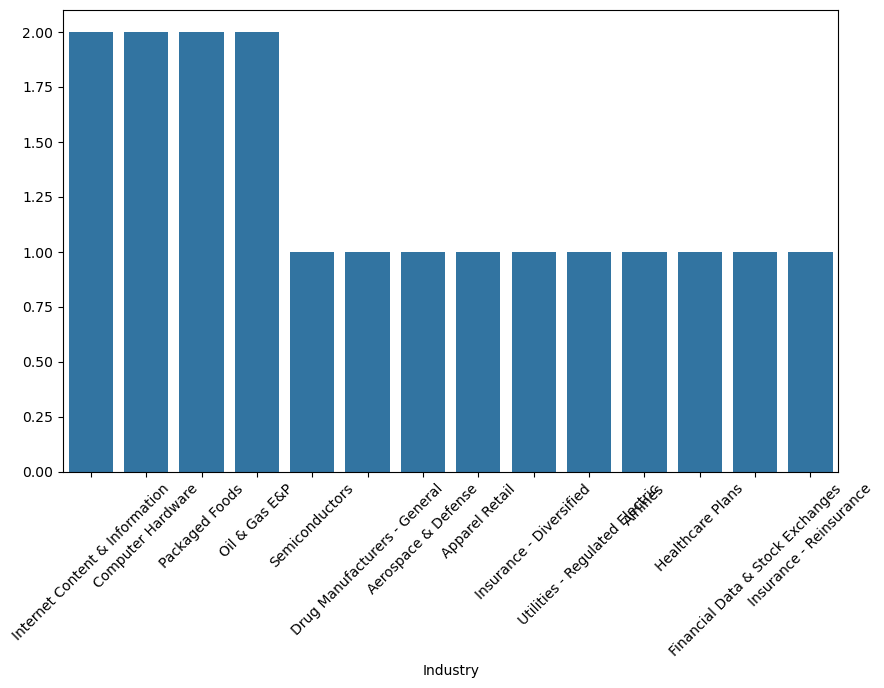

In [200]:
## look at industry distribution
industry_distribution = selected_stocks_metadata['Industry'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=industry_distribution.index, y=industry_distribution.values)
plt.xticks(rotation=45)


In [202]:
selected_stocks_prices = sp500_companies_all_data[selected_stocks]
selected_stocks_prices = selected_stocks_prices.loc[:'2025-01-01']
selected_stocks_returns = selected_stocks_prices.pct_change().dropna()

## Performance on training data

In [218]:
sp500_index_prices = pd.read_csv('data/sp500_index_prices.csv', index_col=0)
sp500_index_prices.index = pd.to_datetime(sp500_index_prices.index)
sp500_index_prices_train = sp500_index_prices.loc[:'2025-01-01']
sp500_index_returns = sp500_index_prices_train.pct_change().dropna()

Portfolio Sharp Ratio: 1.70
Portfolio Max Drawdown: -0.13
SP500 Index Sharp Ratio: ^GSPC    0.787853
dtype: float64
SP500 Index Max Drawdown: ^GSPC   -0.254251
dtype: float64


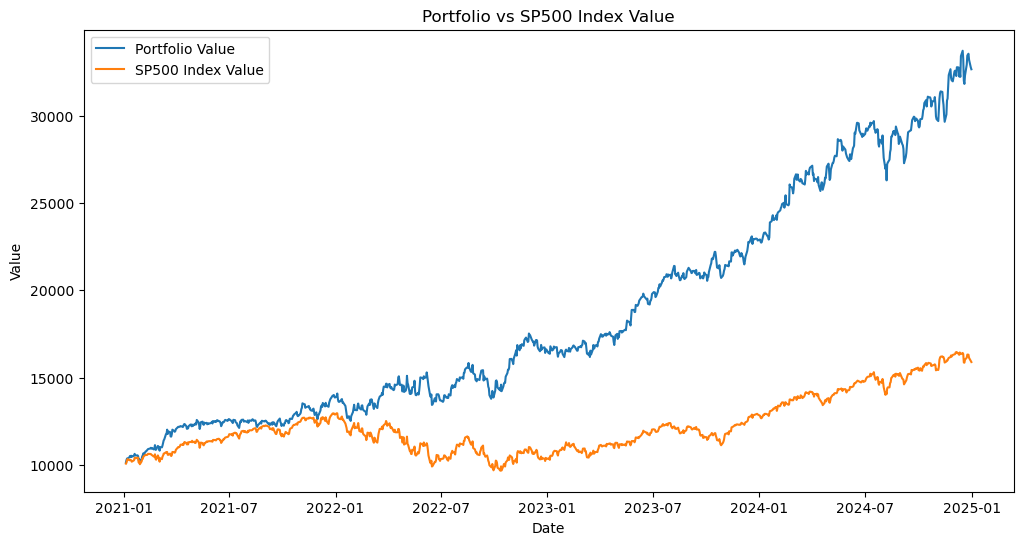

In [219]:
initial_investment = 10_000
weights = opt_weights.values
portfolio_returns = selected_stocks_returns @ weights
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment
sharp_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min()

sp500_index_values = (1 + sp500_index_returns).cumprod() * initial_investment
sp500_index_sharp_ratio = (sp500_index_returns.mean() / sp500_index_returns.std()) * np.sqrt(252)
sp500_index_max_drawdown = (sp500_index_values / sp500_index_values.cummax() - 1).min()
print(f"Portfolio Sharp Ratio: {sharp_ratio:.2f}")
print(f"Portfolio Max Drawdown: {max_drawdown:.2f}")
print(f"SP500 Index Sharp Ratio: {sp500_index_sharp_ratio}")
print(f"SP500 Index Max Drawdown: {sp500_index_max_drawdown}")
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value')
plt.plot(sp500_index_values, label='SP500 Index Value')
plt.title('Portfolio vs SP500 Index Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()


# Evaluate on test data
Data from after Jan 1 2025

Test Portfolio Sharp Ratio: 0.75
Test Portfolio Max Drawdown: -0.19
Test SP500 Index Sharp Ratio: 0.16753331547106107
Test SP500 Index Max Drawdown: -0.18902206184283998


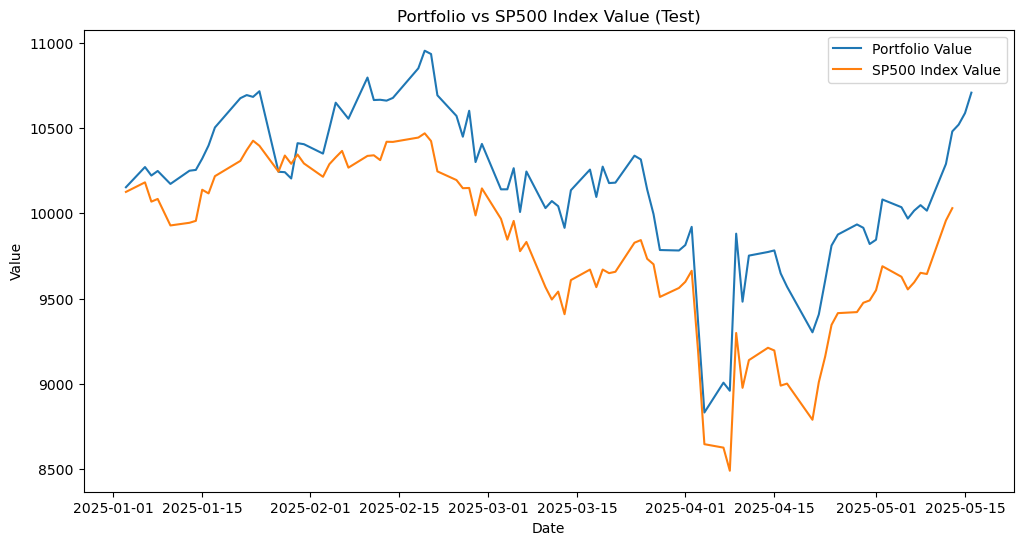

In [227]:
test_data = sp500_companies_all_data.loc['2025-01-01':]
test_data = test_data[selected_stocks]
test_returns = test_data.pct_change().dropna()
test_returns = test_returns.dropna(axis=1)

sp500_index_prices_test = sp500_index_prices.loc['2025-01-01':]
sp500_index_returns_test = sp500_index_prices_test.pct_change().dropna()
initial_investment = 10_000

weights = opt_weights.values
portfolio_returns_test = test_returns @ weights
portfolio_value_test = (1 + portfolio_returns_test).cumprod() * initial_investment
sp500_index_values_test = (1 + sp500_index_returns_test).cumprod() * initial_investment
sharp_ratio_test = (portfolio_returns_test.mean() / portfolio_returns_test.std()) * np.sqrt(252)
max_drawdown_test = (portfolio_value_test / portfolio_value_test.cummax() - 1).min()
sp500_index_sharp_ratio_test = (sp500_index_returns_test.mean() / sp500_index_returns_test.std()) * np.sqrt(252)
sp500_index_max_drawdown_test = (sp500_index_values_test / sp500_index_values_test.cummax() - 1).min()
print(f"Test Portfolio Sharp Ratio: {sharp_ratio_test:.2f}")
print(f"Test Portfolio Max Drawdown: {max_drawdown_test:.2f}")
print(f"Test SP500 Index Sharp Ratio: {sp500_index_sharp_ratio_test.values[0]}")
print(f"Test SP500 Index Max Drawdown: {sp500_index_max_drawdown_test.values[0]}")

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_test, label='Portfolio Value')
plt.plot(sp500_index_values_test, label='SP500 Index Value')
plt.title('Portfolio vs SP500 Index Value (Test)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
